# MNIST 手寫數字辨識：簡單 CNN 範例（Colab 版）

這份 Notebook 示範如何：

1. 讀取 `mnist_train.csv`、`mnist_test.csv` 資料集  
2. 前處理資料（正規化、shape 調整、one-hot 編碼）  
3. 使用 Keras 建立一個「一層卷積 + 一層池化」的簡單 CNN 模型  
4. 訓練並評估模型效能  
5. 指定一筆測試資料，顯示影像與模型辨識結果  

> 請先把 `mnist_train.csv` 和 `mnist_test.csv` 檔案上傳到 Colab 的工作目錄（通常是 `/content/`）。


## 1. 匯入套件

這裡我們會用到：

- `pandas` 讀取 CSV  
- `numpy` 做數值運算  
- `matplotlib` 視覺化影像與訓練過程  
- `tensorflow.keras` 建立 CNN 模型


In [2]:
# 匯入必要的套件
import numpy as np               # 數值運算
import pandas as pd              # 讀取與處理表格資料
import matplotlib.pyplot as plt  # 畫圖

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# 設定隨機種子，讓結果比較可重現
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow 版本：", tf.__version__)

TensorFlow 版本： 2.19.0


## 2. 讀取 MNIST CSV 資料

假設：

- 訓練檔：`mnist_train.csv`  
- 測試檔：`mnist_test.csv`  

每一列的格式：

- 第 0 欄：標籤（0~9 的數字）  
- 第 1~784 欄：28×28 灰階影像攤平成 784 維的像素值（0~255）


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# === 請確認檔名與路徑 ===
train_path = "/content/drive/MyDrive/Colab Notebooks/Vibe Coding/Data/mnist_train.csv"  # 例如："/content/mnist_train.csv"
test_path  = "/content/drive/MyDrive/Colab Notebooks/Vibe Coding/Data/mnist_test.csv"   # 例如："/content/mnist_test.csv"

# 使用 pandas 讀取 CSV
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# 顯示前幾列，確認資料格式
train_df.head()

Train shape: (60000, 785)
Test shape: (10000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. 資料前處理

步驟：

1. 分出特徵（像素）與標籤（0~9）。  
2. 將像素從 0~255 正規化到 0~1。  
3. 將 784 維向量 reshape 成 `(28, 28, 1)`，當作灰階影像。  
4. 標籤做 one-hot 編碼（10 維）。


In [5]:
# 把 DataFrame 轉成 numpy 陣列
train_data = train_df.values.astype(np.float32)
test_data  = test_df.values.astype(np.float32)

# 第 0 欄是標籤（0~9）
y_train = train_data[:, 0].astype(int)
y_test  = test_data[:, 0].astype(int)

# 第 1~784 欄是像素
X_train = train_data[:, 1:]
X_test  = test_data[:, 1:]

print("原始 X_train shape:", X_train.shape)
print("原始 X_test  shape:", X_test.shape)

# 像素從 0~255 正規化到 0~1
X_train = X_train / 255.0
X_test  = X_test / 255.0

# 轉成 CNN 所需的影像格式 (N, 28, 28, 1)
# - N: 筆數
# - 28x28: 影像大小
# - 1: 單通道（灰階）
X_train = X_train.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

print("轉成影像後 X_train shape:", X_train.shape)
print("轉成影像後 X_test  shape:", X_test.shape)

# 將標籤轉成 one-hot 編碼
num_classes = 10  # 數字 0~9
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

print("y_train one-hot shape:", y_train_cat.shape)
print("y_test  one-hot shape:", y_test_cat.shape)

原始 X_train shape: (60000, 784)
原始 X_test  shape: (10000, 784)
轉成影像後 X_train shape: (60000, 28, 28, 1)
轉成影像後 X_test  shape: (10000, 28, 28, 1)
y_train one-hot shape: (60000, 10)
y_test  one-hot shape: (10000, 10)


## 4. 建立簡單 CNN 模型

本範例的 CNN 結構：

1. **卷積層 (Conv2D)**：32 個 3×3 濾波器，啟動函數 ReLU  
2. **池化層 (MaxPooling2D)**：2×2 最大池化，降採樣、減少參數  
3. **Flatten 展平**：把 feature map 攤平成一維向量  
4. **全連接層 (Dense)**：128 個神經元，ReLU  
5. **輸出層 (Dense)**：10 個神經元，Softmax（對應 10 類數字）

損失函數使用 `categorical_crossentropy`（因為我們有 one-hot 標籤），
優化器使用 `Adam`。


In [6]:
# 建立序列式(Sequential) CNN 模型
model = Sequential()

# 1. 卷積層：一層 Conv2D
model.add(Conv2D(
    filters=32,              # 濾波器數量（輸出 feature map 數）
    kernel_size=(3, 3),      # 濾波器大小
    activation='relu',       # 啟動函數
    input_shape=(28, 28, 1)  # 輸入影像大小 (高度, 寬度, 通道數)
))

# 2. 池化層：一層 MaxPooling2D
model.add(MaxPooling2D(pool_size=(2, 2)))  # 2x2 最大池化

# 3. 將 2D feature map 攤平
model.add(Flatten())

# 4. 全連接層 (隱藏層)
model.add(Dense(128, activation='relu'))

# 5. 輸出層：10 類 (0~9)
model.add(Dense(10, activation='softmax'))

# 編譯模型
model.compile(
    optimizer='adam',                   # 最常用的一種 optimizer
    loss='categorical_crossentropy',    # 多類別分類（one-hot）常用的 loss
    metrics=['accuracy']                # 額外關心的指標
)

# 顯示模型結構
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,962 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

## 5. 訓練模型

這裡我們用：

- `epochs=5`：訓練 5 個世代（可自行調整）  
- `batch_size=128`：每次更新使用 128 筆資料  

並以 `X_test, y_test_cat` 作為驗證集，觀察訓練過程中的 loss / accuracy 變化。


In [7]:
# 開始訓練 CNN 模型
epochs = 5       # 可以改大一點（例如 10），效果通常會更好
batch_size = 128

history = model.fit(
    X_train, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test_cat)
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.8717 - loss: 0.4511 - val_accuracy: 0.9717 - val_loss: 0.0891
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - accuracy: 0.9786 - loss: 0.0751 - val_accuracy: 0.9796 - val_loss: 0.0645
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - accuracy: 0.9857 - loss: 0.0493 - val_accuracy: 0.9818 - val_loss: 0.0533
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.9899 - loss: 0.0355 - val_accuracy: 0.9833 - val_loss: 0.0506
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 69ms/step - accuracy: 0.9933 - loss: 0.0260 - val_accuracy: 0.9835 - val_loss: 0.0510


## 6. 視覺化訓練過程（Loss / Accuracy 曲線）

為了理解模型有沒有 overfitting 或 underfitting，我們可以把：

- Training / Validation 的 loss  
- Training / Validation 的 accuracy  

畫成隨著 epochs 變化的折線圖。


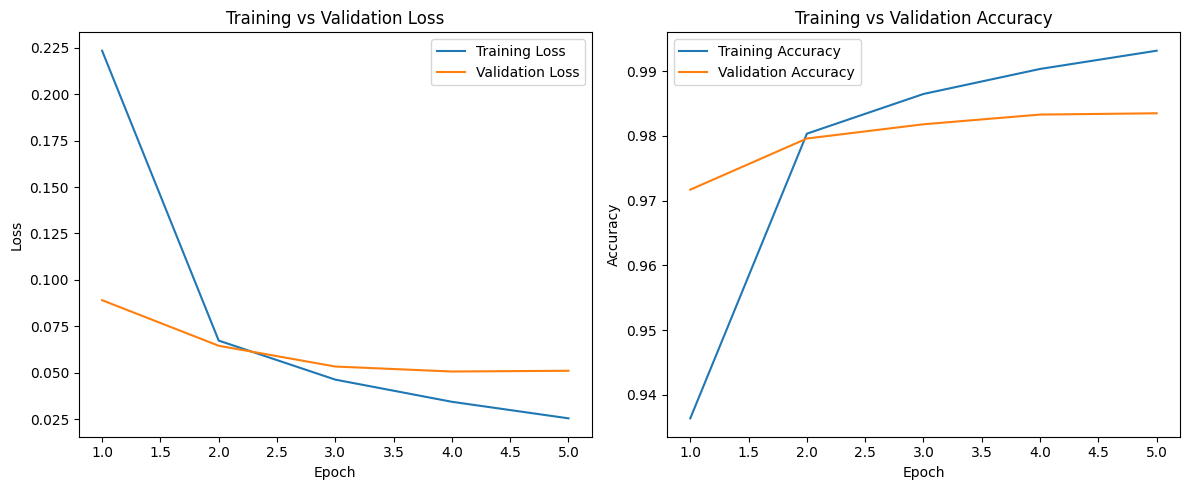

In [8]:
# 繪製 Loss / Accuracy 曲線

# 取得訓練過程紀錄
history_dict = history.history

# 建立 x 軸（epoch 編號）
epochs_range = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(12, 5))

# ---------- 子圖 1：Loss ----------
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_dict['loss'], label='Training Loss')
plt.plot(epochs_range, history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# ---------- 子圖 2：Accuracy ----------
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_dict['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 7. 在測試資料上評估模型

使用 `model.evaluate()` 可以得到：

- 測試集 Loss  
- 測試集 Accuracy  


In [9]:
# 在測試集上評估模型表現
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0510
Test Accuracy: 0.9835


## 8. 指定一筆測試資料，顯示圖片與辨識結果

我們希望做到：

1. 可以指定一個測試資料的編號（index）。  
2. 顯示這張 28×28 的灰階圖片。  
3. 模型輸出該圖片為 0~9 的機率分佈，並顯示「模型預測結果」與「真實標籤」。

> 注意：index 介於 `0` 到 `len(X_test)-1` 之間。


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
真實標籤 (True Label): 7
模型預測 (Predicted Label): 7
預測機率 (Confidence): 100.00%


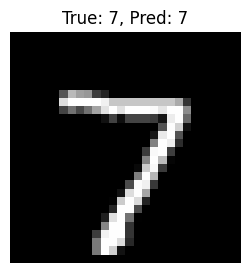

數字 0: 機率 0.0000
數字 1: 機率 0.0000
數字 2: 機率 0.0000
數字 3: 機率 0.0000
數字 4: 機率 0.0000
數字 5: 機率 0.0000
數字 6: 機率 0.0000
數字 7: 機率 1.0000
數字 8: 機率 0.0000
數字 9: 機率 0.0000


In [10]:
# === 手動指定一筆測試資料的 index ===
# 你可以改這個數字來看不同的測試樣本
test_index = 0  # 範例：先看第 0 筆

# 取出對應的影像與標籤
sample_image = X_test[test_index]      # shape: (28, 28, 1)
sample_label = y_test[test_index]      # true label (0~9)

# Keras 的 model.predict 需要輸入一個「batch」
sample_input = np.expand_dims(sample_image, axis=0)  # shape: (1, 28, 28, 1)

# 進行預測，得到 10 類的機率分佈
pred_probs = model.predict(sample_input)

# 取出機率最高的類別
pred_label = np.argmax(pred_probs[0])
pred_confidence = np.max(pred_probs[0])

print("真實標籤 (True Label):", sample_label)
print("模型預測 (Predicted Label):", pred_label)
print("預測機率 (Confidence): {:.2f}%".format(pred_confidence * 100))

# 顯示這張圖片
plt.figure(figsize=(3, 3))
plt.imshow(sample_image.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title(f"True: {sample_label}, Pred: {pred_label}")
plt.show()

# 顯示每個數字的機率
for digit, prob in enumerate(pred_probs[0]):
    print(f"數字 {digit}: 機率 {prob:.4f}")

## 9. 小結

在這份 Notebook 中，我們完成了：

- 從 CSV 讀取 MNIST 手寫數字資料  
- 資料前處理（正規化、reshape 成影像、one-hot 編碼）  
- 建立一個簡單的 CNN（1 層卷積 + 1 層池化）  
- 訓練並評估模型效能  
- 指定一筆測試資料，顯示圖片與模型辨識結果  

你可以嘗試：

- 增加卷積層或全連接層  
- 調整 epoch、batch_size、learning rate  
- 加入 Dropout 觀察過擬合情況是否改善  


## 10. 混淆矩陣 (Confusion Matrix) 視覺化

除了整體 Accuracy 以外，我們也想知道：

- 哪些數字容易被模型辨識錯？
- 例如「5 常被分成 3」，或「9 常被分成 4」等等。

這時可以使用「混淆矩陣 (confusion matrix)」來觀察：

- 橫軸：模型預測的類別
- 縱軸：真實的類別
- 對角線：預測正確的數量
- 其他格子：預測錯誤的次數

我們會先用 `model.predict` 算出每一筆測試資料的預測類別，再用
`sklearn.metrics.confusion_matrix` 建立矩陣，最後用 heatmap 顯示。


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
Confusion Matrix：
[[ 970    0    2    0    0    1    3    1    3    0]
 [   0 1122    2    1    0    2    2    1    5    0]
 [   1    3 1014    0    0    1    0    5    8    0]
 [   0    0    0  997    0    9    0    2    2    0]
 [   1    0    4    0  942    0    2    2   10   21]
 [   1    0    0    4    0  885    2    0    0    0]
 [   3    1    0    0    1    3  947    0    3    0]
 [   0    1    7    3    0    0    0 1009    3    5]
 [   4    0    1    2    0    3    2    2  958    2]
 [   2    0    0    2    0    4    0    3    7  991]]


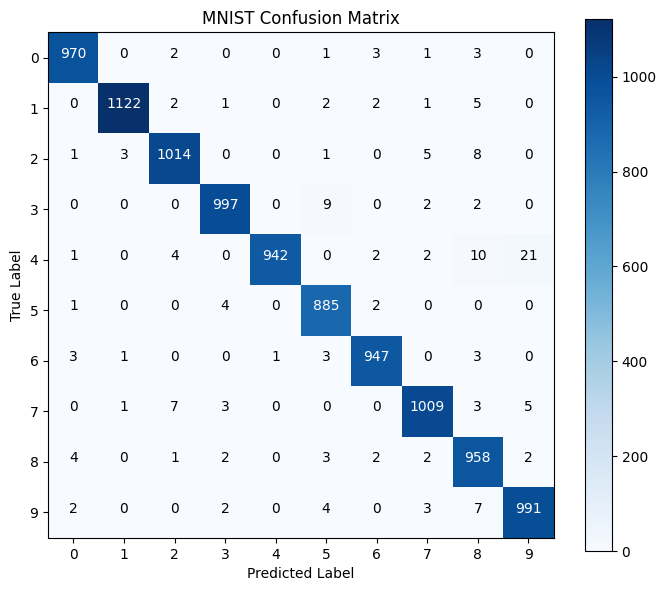

In [11]:
# =========================================
# 10. 混淆矩陣 (Confusion Matrix) heatmap
# =========================================

from sklearn.metrics import confusion_matrix
import itertools  # 用來在雙重迴圈標註文字（可選）

# 1. 先用模型對測試集做預測（得到 10 類機率）
y_pred_probs = model.predict(X_test)  # shape: (num_samples, 10)

# 2. 取出每一筆樣本機率最高的類別 index，作為預測標籤
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)

# 3. 建立混淆矩陣
#   - y_test：真實標籤 (0~9)，之前前處理時就保留了
#   - y_pred：模型預測標籤 (0~9)
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix：")
print(cm)

# 4. 以 heatmap 方式畫出混淆矩陣
plt.figure(figsize=(7, 6))

# imshow 類似熱度圖，cmap='Blues' 使用藍色系顏色
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("MNIST Confusion Matrix")
plt.colorbar()  # 右側顏色刻度條

# 設定 x, y 軸刻度與標籤（0~9）
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 5. 在每一個格子上標上數字（出現次數）
#   - i：真實標籤 (row)
#   - j：預測標籤 (col)
thresh = cm.max() / 2.0  # 閥值，用來決定文字顏色（深淺背景）
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j, i,            # 位置 (x=j, y=i)
        cm[i, j],        # 顯示的數字（該格子的次數）
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )

plt.tight_layout()
plt.show()
